# **Pneumonia Chest X-Ray Classification**

The dataset is structured into three folders—train, test, and validation—each containing subfolders corresponding to the image categories: Pneumonia and Normal. It comprises 5,863 JPEG-format chest X-ray images, categorized into these two classes.

#### IMPORTING THE LIBRARIES

In [1]:
import os
import zipfile
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#### LOADING THE DATASET

In [2]:
def load_all_images(zip_file_path, base_folder='chest_xray', subsets=['train', 'test', 'val'], classes=['NORMAL', 'PNEUMONIA'], image_size=(224, 224), convert_to_rgb=True):
    data = []
    labels = []

    # Open the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as z:
        # Loop through subsets (train, test, val)
        for subset in subsets:
            # Loop through each class folder
            for class_label, class_name in enumerate(classes):
                # Construct the folder path for the current subset and class
                class_folder = f"{base_folder}/{subset}/{class_name}/"

                for file_name in z.namelist():
                    # Ensure the file is in the correct folder and is a JPEG image
                    if file_name.startswith(class_folder) and file_name.endswith('.jpeg'):
                        try:
                            with z.open(file_name) as file:
                                # Read and decode the image in grayscale
                                image = cv2.imdecode(np.frombuffer(file.read(), np.uint8), cv2.IMREAD_GRAYSCALE)
                                if image is not None:
                                    # Convert grayscale to RGB if required
                                    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
                                    # Resize the image to the specified dimensions
                                    image = cv2.resize(image, image_size)
                                    data.append(image)
                                    labels.append(class_label)
                                else:
                                    print(f"Warning: Unable to decode image: {file_name}")
                        except Exception as e:
                            print(f"Error processing file {file_name}: {e}")

    if not data:
        print("No images loaded. Please check the folder structure or file paths.")

    # Check total images loaded for each class
    print(f"Total images loaded: {len(data)}")
    print(f"Label counts: {np.bincount(labels)}")  # Count of each label (e.g., [#normal, #pneumonia])

    return data, labels

In [3]:
# DATASET FILE PATH
zip_file_path = 'Chest-Xray-2.zip'
classes = ['NORMAL', 'PNEUMONIA']

# Load all images and labels
data, labels = load_all_images(zip_file_path, classes=classes)

# Convert lists to numpy array
data = np.array(data, dtype='float32') / 255.0  # Normalize pixel values to [0, 1]
labels = np.array(labels, dtype='int32')

# **Checking the total number of images and labels loaded**
print(f"Total images loaded: {len(data)}")
print(f"Total labels loaded: {len(labels)}")


Total images loaded: 5856
Label counts: [1583 4273]
Total images loaded: 5856
Total labels loaded: 5856


**OBSERVATION**
1. Total images loaded : **5856**
2. The total number of **NORMAL** images : **1583**
3. The total number of **PNEUMONIA** images : **4273**
4. It is seen that there is a class imbalance in the images dataset. The minority class (NORMAL) is adjusted using data augmentation.

#### ADJUSTING DATA IMBALANCE USING DATA AUGMENTATION

In [4]:
# Create an image data generator for the minority class
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

# Use the generator to augment images for the minority class
augmented_data = []
augmented_labels = []
for image, label in zip(data, labels):
    if label == 0:  #  0 corresponds to the minority class
        for _ in range(1):  # Generate 10 augmented samples per image
            augmented_image = datagen.random_transform(image)
            augmented_data.append(augmented_image)
            augmented_labels.append(label)

# Combine original and augmented data
data = np.concatenate((data, np.array(augmented_data)), axis=0)
labels = np.concatenate((labels, np.array(augmented_labels)), axis=0)

# **Check: Class distribution in each augmentation**
print("\nClass distribution after augmentation:")
print(f"labels: {np.bincount(labels)}")

# Images and Labels shapes
print(f" data shape: {data.shape}, Labels shape: {labels.shape}")


Class distribution after augmentation:
labels: [3166 4273]
 data shape: (7439, 224, 224, 3), Labels shape: (7439,)


**OBSERVATION**
1. Total images after augmentation : **7439**
2. The total number of **NORMAL** images after augmentation : **3166**
3. The total number of **PNEUMONIA** images after augmentation : **4273**

In [5]:
# Applying Train Test Spilt
def split_data(data, labels, test_size=0.2, val_size=0.2, random_state=42):
    # First, split the data into train+test and test sets
    train_val_data, test_data, train_val_labels, test_labels = train_test_split(
        data, labels, test_size=test_size, random_state=random_state, stratify=labels, shuffle=True
    )
    # Next, split the train+val set into training and validation sets
    train_data, val_data, train_labels, val_labels = train_test_split(
        train_val_data, train_val_labels, test_size=val_size, random_state=random_state, stratify=train_val_labels, shuffle=True
    )

    # **Check: Class distribution in each split**
    print("\nClass distribution after splitting:")
    print(f"Train set: {np.bincount(train_labels)}")
    print(f"Validation set: {np.bincount(val_labels)}")
    print(f"Test set: {np.bincount(test_labels)}")

    return train_data, val_data, test_data, train_labels, val_labels, test_labels

In [6]:
# Split the data into training, validation, and test sets
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data, labels)

print(f"Training data shape: {X_train.shape}, Labels data shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels data shape: {y_val.shape}")
print(f"Testing data shape: {X_test.shape}, Labels data shape: {y_test.shape}")


Class distribution after splitting:
Train set: [2026 2734]
Validation set: [507 684]
Test set: [633 855]
Training data shape: (4760, 224, 224, 3), Labels data shape: (4760,)
Validation data shape: (1191, 224, 224, 3), Labels data shape: (1191,)
Testing data shape: (1488, 224, 224, 3), Labels data shape: (1488,)


**OBSERVATION**
- **Class distribution after Train Test Spilt**
1. Train set - **NORMAL: 2026, PNEUMONIA: 2734**
2. Validation set: - **NORMAL: 507, PNEUMONIA: 684**
3. Test set: - **NORMAL: 633, PNEUMONIA: 855**

## BUILDING THE MODELS

#### 1. CUSTOM CNN MODEL

In [7]:
# Cusom CNN Model
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Model summary
model_cnn.summary()

# Compiling the model
model_cnn.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

C:\Users\viswa\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,218 (42.61 MB)

 Trainable params: 11,169,218 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Traing the model
history_cnn = model_cnn.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    batch_size=32)

Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.6744 - loss: 0.5891 - val_accuracy: 0.8363 - val_loss: 0.3978
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.9130 - loss: 0.2295 - val_accuracy: 0.8984 - val_loss: 0.2338
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.9312 - loss: 0.1867 - val_accuracy: 0.9253 - val_loss: 0.1869
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.9410 - loss: 0.1572 - val_accuracy: 0.9353 - val_loss: 0.1637
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.9496 - loss: 0.1364 - val_accuracy: 0.9320 - val_loss: 0.1641
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - accuracy: 0.9474 - loss: 0.1418 - val_accuracy: 0.9353 - val_loss: 0.1552
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.9555 - loss: 0.1197 - val_accuracy: 0.9337 - val_loss: 0.1539
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.9624 - loss: 0.1043 - val_accu

In [9]:
# Evaluating the model
cnn_loss, cnn_accuracy = model_cnn.evaluate(X_test, y_test)
print(f"CNN Model - Loss: {cnn_loss}, Accuracy: {cnn_accuracy}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 422ms/step - accuracy: 0.9594 - loss: 0.1219
CNN Model - Loss: 0.1310184895992279, Accuracy: 0.9590053558349609


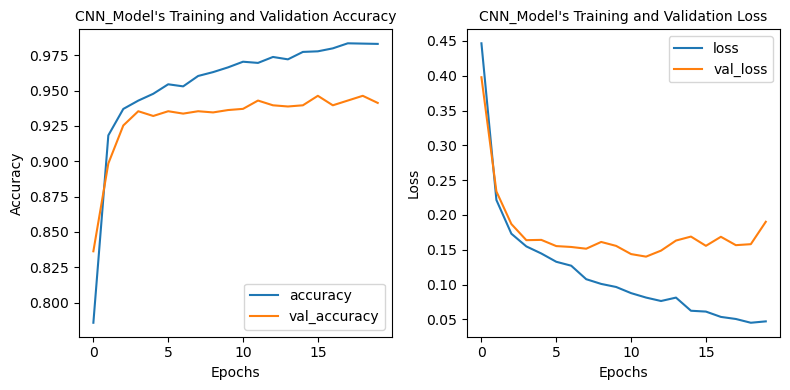

In [10]:
# Custom CNN Accuracy and Loss plot
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("CNN_Model's Training and Validation Accuracy",  fontsize=10)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='loss')
plt.plot(history_cnn.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("CNN_Model's Training and Validation Loss", fontsize=10)
plt.legend()


plt.tight_layout()
plt.show()

In [11]:
# Prediction
y_pred_cnn = np.argmax(model_cnn.predict(X_test), axis=1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 349ms/step


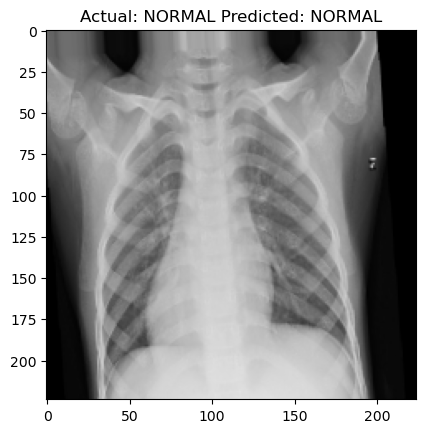

In [12]:
# Checking the prediction
plt.imshow(X_test[30])
plt.title(f"Actual: {classes[y_test[30]]} Predicted: {classes[y_pred_cnn[30]]}")
plt.show()

              precision    recall  f1-score   support

      NORMAL       0.96      0.95      0.95       633
   PNEUMONIA       0.96      0.97      0.96       855

    accuracy                           0.96      1488
   macro avg       0.96      0.96      0.96      1488
weighted avg       0.96      0.96      0.96      1488



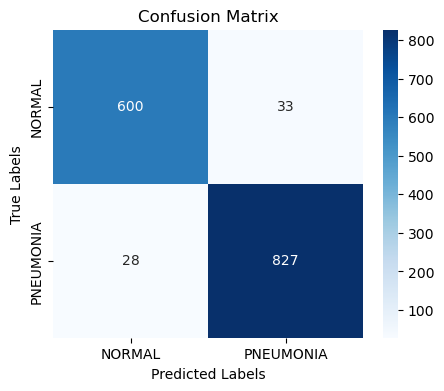

In [13]:
# Classification Report
print(classification_report(y_test, y_pred_cnn, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### TRANSFER LEARNING TECHNIQUES

### 2. VGG16 MODEL

In [14]:
# Loading vgg16 without top layer
base_model_vgg16 = VGG16(weights='imagenet', include_top = False, input_shape = (224, 224, 3))

# Freeze the convolutional layer
base_model_vgg16.trainable = False

In [15]:
# VGG 16 Model
model_vgg16 = Sequential([
    base_model_vgg16,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

# Model summary
model_vgg16.summary()

# Compiling the model
model_vgg16.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy']
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,926,338 (68.38 MB)

 Trainable params: 3,211,650 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
# Training the model
history_vgg16 = model_vgg16.fit(
    X_train, y_train,
    epochs=5,
    validation_data=(X_val, y_val),
    batch_size=32)

Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 1817s 12s/step - accuracy: 0.9714 - loss: 0.0838 - val_accuracy: 0.9639 - val_loss: 0.1036
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 2126s 14s/step - accuracy: 0.9748 - loss: 0.0692 - val_accuracy: 0.9647 - val_loss: 0.0944
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 2208s 15s/step - accuracy: 0.9799 - loss: 0.0603 - val_accuracy: 0.9631 - val_loss: 0.0965
Epoch 4/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 2509s 17s/step - accuracy: 0.9800 - loss: 0.0591 - val_accuracy: 0.9622 - val_loss: 0.1029
Epoch 5/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 2430s 16s/step - accuracy: 0.9815 - loss: 0.0516 - val_accuracy: 0.9664 - val_loss: 0.0912


In [18]:
# Evaluating the model
vgg16_loss, vgg16_accuracy = model_vgg16.evaluate(X_test, y_test)
print(f"VGG16 Model - Loss: {vgg16_loss}, Accuracy: {vgg16_accuracy}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 660s 14s/step - accuracy: 0.9680 - loss: 0.0927
VGG16 Model - Loss: 0.08857163041830063, Accuracy: 0.9663978219032288


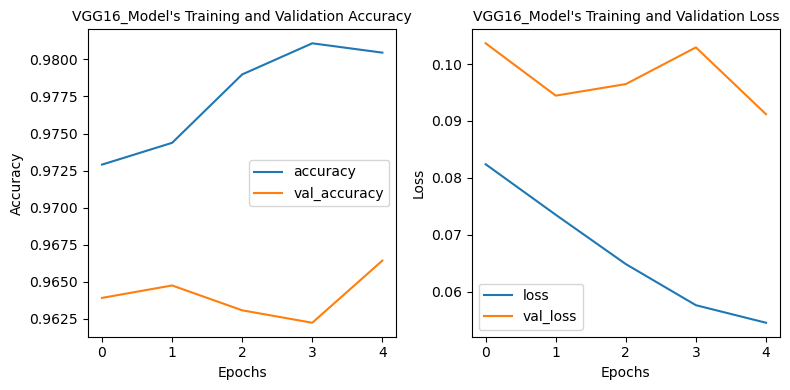

In [19]:
# Custom VGG16 Accuracy and Loss plot
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(history_vgg16.history['accuracy'], label='accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("VGG16_Model's Training and Validation Accuracy", fontsize=10)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_vgg16.history['loss'], label='loss')
plt.plot(history_vgg16.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("VGG16_Model's Training and Validation Loss", fontsize=10)
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
# Prediction
y_pred_vgg16 = np.argmax(model_vgg16.predict(X_test), axis=1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 627s 13s/step


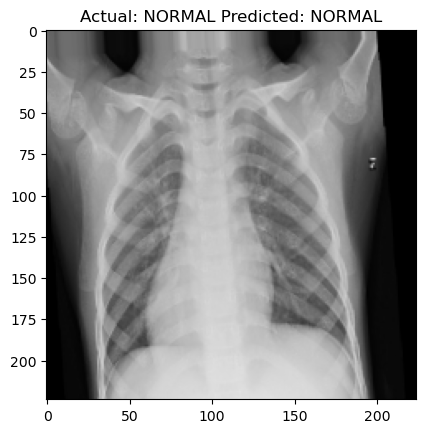

In [21]:
# Checking the prediction
plt.imshow(X_test[30])
plt.title(f"Actual: {classes[y_test[30]]} Predicted: {classes[y_pred_vgg16[30]]}")
plt.show()

              precision    recall  f1-score   support

      NORMAL       0.97      0.95      0.96       633
   PNEUMONIA       0.97      0.98      0.97       855

    accuracy                           0.97      1488
   macro avg       0.97      0.96      0.97      1488
weighted avg       0.97      0.97      0.97      1488



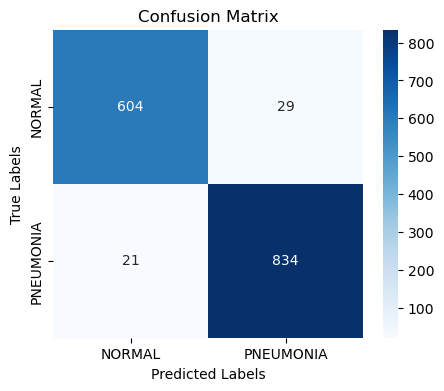

In [22]:
# Classification Report
print(classification_report(y_test, y_pred_vgg16, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_vgg16)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### 3. RESNET50 Model

In [24]:
# Loading ResNet50 without top layer
base_model_resnet50 = ResNet50(weights='imagenet', include_top = False, input_shape = (224, 224, 3))

# Freeze the convolutional layer
base_model_resnet50.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step


In [25]:
# Building ResNet50 Model
model_resnet50 = Sequential([
    base_model_resnet50,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

# Model Summary
model_resnet50.summary()

# Compiling the Model
model_resnet50.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy']
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,433,154 (138.98 MB)

 Trainable params: 12,845,442 (49.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [26]:
# Training the Model
history_resnet50 = model_resnet50.fit(
    X_train, y_train,
    epochs=5,
    validation_data=(X_val, y_val),
    batch_size=32)

Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 553s 4s/step - accuracy: 0.5866 - loss: 0.8909 - val_accuracy: 0.7817 - val_loss: 0.5613
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 735s 5s/step - accuracy: 0.7222 - loss: 0.5593 - val_accuracy: 0.7246 - val_loss: 0.5036
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 816s 5s/step - accuracy: 0.7769 - loss: 0.4912 - val_accuracy: 0.8329 - val_loss: 0.4296
Epoch 4/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 689s 5s/step - accuracy: 0.8001 - loss: 0.4645 - val_accuracy: 0.8220 - val_loss: 0.3922
Epoch 5/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 659s 4s/step - accuracy: 0.8127 - loss: 0.4367 - val_accuracy: 0.8514 - val_loss: 0.3718


In [27]:
# Evaluating the model
resnet50_loss, resnet50_accuracy = model_resnet50.evaluate(X_test, y_test)
print(f"RESNET50 Model - Loss: {resnet50_loss}, Accuracy: {resnet50_accuracy}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 166s 4s/step - accuracy: 0.8609 - loss: 0.3587
RESNET50 Model - Loss: 0.36369815468788147, Accuracy: 0.8568548560142517


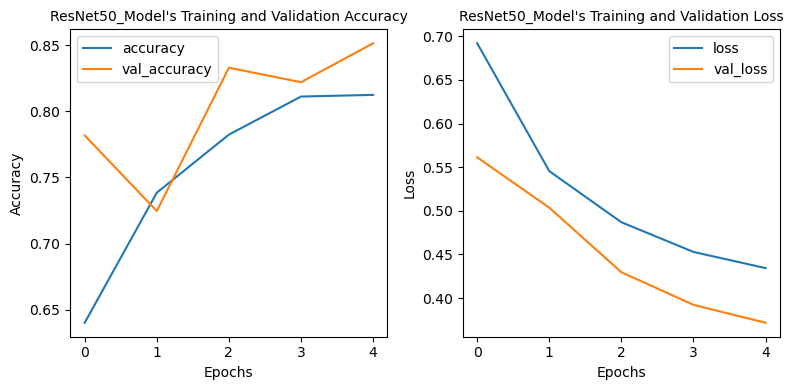

In [28]:
# Custom RESNET50 Accuracy and Loss plot
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(history_resnet50.history['accuracy'], label='accuracy')
plt.plot(history_resnet50.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("ResNet50_Model's Training and Validation Accuracy", fontsize=10)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_resnet50.history['loss'], label='loss')
plt.plot(history_resnet50.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("ResNet50_Model's Training and Validation Loss", fontsize=10)
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
# Prediction
y_pred_resnet50 = np.argmax(model_resnet50.predict(X_test), axis=1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step


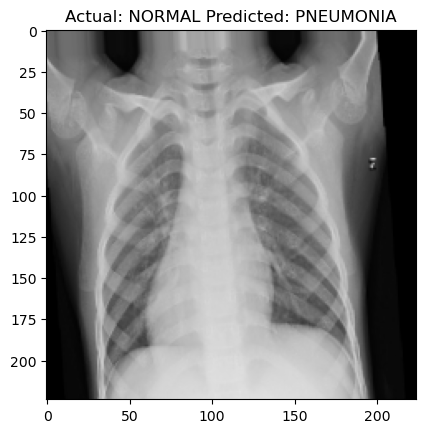

In [30]:
# Checking the prediction
plt.imshow(X_test[30])
plt.title(f"Actual: {classes[y_test[30]]} Predicted: {classes[y_pred_resnet50[30]]}")
plt.show()

              precision    recall  f1-score   support

      NORMAL       0.83      0.83      0.83       633
   PNEUMONIA       0.87      0.88      0.88       855

    accuracy                           0.86      1488
   macro avg       0.85      0.85      0.85      1488
weighted avg       0.86      0.86      0.86      1488



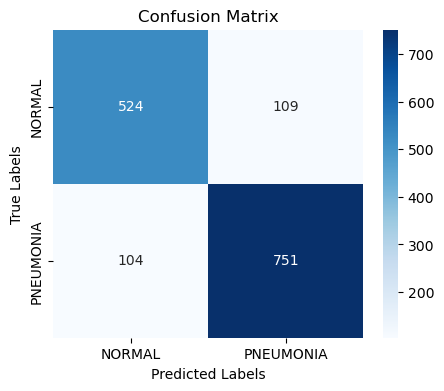

In [31]:
# Classification Report
print(classification_report(y_test, y_pred_resnet50, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_resnet50)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### 4. INCEPTION V3 MODEL

In [41]:
# Loading InceptionV3 without top layer
base_model_inceptionv3 = InceptionV3(weights='imagenet', include_top = False, input_shape = (224, 224, 3))

# Freeze the convolutional layer
base_model_inceptionv3.trainable = False

In [42]:
# Building Inception V3 Model
model_inceptionv3 = Sequential([
    base_model_inceptionv3,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

# Model summary
model_inceptionv3.summary()

# Compiling the model
model_inceptionv3.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy']
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,356,770 (108.17 MB)

 Trainable params: 6,553,986 (25.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [43]:
# Training the model
history_inceptionv3 = model_inceptionv3.fit(
    X_train, y_train,
    epochs=5,
    validation_data=(X_val, y_val),
    batch_size=32)

Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.8224 - loss: 0.5734 - val_accuracy: 0.9312 - val_loss: 0.1726
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 378s 3s/step - accuracy: 0.9232 - loss: 0.1949 - val_accuracy: 0.9295 - val_loss: 0.1752
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.9472 - loss: 0.1434 - val_accuracy: 0.9362 - val_loss: 0.1586
Epoch 4/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 442s 3s/step - accuracy: 0.9557 - loss: 0.1241 - val_accuracy: 0.9404 - val_loss: 0.1446
Epoch 5/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 497s 3s/step - accuracy: 0.9631 - loss: 0.1085 - val_accuracy: 0.9446 - val_loss: 0.1496


In [44]:
# Evaluating the model
inceptionv3_loss, inceptionv3_accuracy = model_inceptionv3.evaluate(X_test, y_test)
print(f"INCEPTION V3 Model - Loss: {inceptionv3_loss}, Accuracy: {inceptionv3_accuracy}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9444 - loss: 0.1442
INCEPTION V3 Model - Loss: 0.1402270644903183, Accuracy: 0.9442204236984253


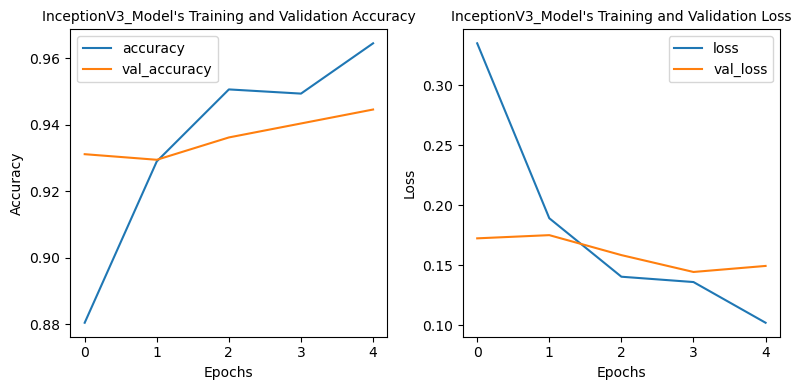

In [45]:
# Custom InceptionV3 Accuracy and Loss plot
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(history_inceptionv3.history['accuracy'], label='accuracy')
plt.plot(history_inceptionv3.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("InceptionV3_Model's Training and Validation Accuracy", fontsize=10)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_inceptionv3.history['loss'], label='loss')
plt.plot(history_inceptionv3.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("InceptionV3_Model's Training and Validation Loss", fontsize=10)
plt.legend()

plt.tight_layout()
plt.show()

In [48]:
# Prediction
y_pred_inceptionv3 = np.argmax(model_inceptionv3.predict(X_test), axis=1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step


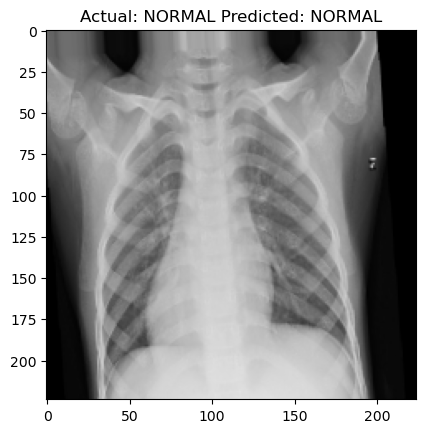

In [49]:
# Checking the prediction
plt.imshow(X_test[30])
plt.title(f"Actual: {classes[y_test[30]]} Predicted: {classes[y_pred_inceptionv3[30]]}")
plt.show()

              precision    recall  f1-score   support

      NORMAL       0.96      0.91      0.93       633
   PNEUMONIA       0.93      0.97      0.95       855

    accuracy                           0.94      1488
   macro avg       0.95      0.94      0.94      1488
weighted avg       0.94      0.94      0.94      1488



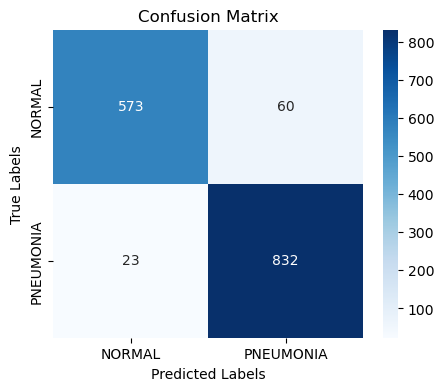

In [50]:
# Classification Report
print(classification_report(y_test, y_pred_inceptionv3, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_inceptionv3)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### SUMMARIZING THE RESULTS

In [51]:
def summarize_reports(models, model_names, X_test, y_test):
    results_list = []

    for model, model_name in zip(models, model_names):

        # Prediction
        y_pred = np.argmax(model.predict(X_test), axis=1)

        # Generate classification report as a dictionary
        report = classification_report(y_test, y_pred, output_dict=True)

        # Extract desired metrics
        metrics = {
            "Model": model_name,
            "Accuracy": report["accuracy"],
            "Precision (macro avg)": report["macro avg"]["precision"],
            "Recall (macro avg)": report["macro avg"]["recall"],
            "F1 Score (macro avg)": report["macro avg"]["f1-score"]
        }

        # Append to results list
        results_list.append(metrics)

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results_list)
    return results_df

# Example usage
models = [model_cnn, model_vgg16, model_resnet50, model_inceptionv3]
model_names = ["Custom CNN Model", "VGG16 Model", "ResNet50 Model", "model_inceptionv3"]

# Generate summary reports
summary_df = summarize_reports(models, model_names, X_test, y_test)

# Display the results
summary_df


47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 473ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 598s 13s/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 188s 4s/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step


,Model,Accuracy,Precision (macro avg),Recall (macro avg),F1 Score (macro avg)
0,Custom CNN Model,0.959005,0.958521,0.957559,0.958029
1,VGG16 Model,0.966398,0.966398,0.964813,0.965575
2,ResNet50 Model,0.856855,0.853825,0.853083,0.853444
3,model_inceptionv3,0.944220,0.947072,0.939156,0.942478


In [52]:
# Save models
model_cnn.save("model_cnn.h5")
model_vgg16.save("model_vgg16.h5")
model_resnet50.save("model_resnet50.h5")
model_inceptionv3.save("model_inceptionv3.h5")

## **SUMMARY**

**DATASET**
- The dataset used in this project is a collection of chest X-ray images stored in a ZIP file, with a structured folder hierarchy containing three subsets: train, test, and val. Each of these subsets is further divided into two categories: NORMAL (healthy lungs) and PNEUMONIA (lungs infected with pneumonia). The images are in grayscale format and need to be preprocessed before being fed into a deep learning model. Instead of extracting the dataset, we implemented a function to load images directly from the ZIP file, ensuring efficient memory usage. The dataset is then combined into a single training set, which is later split into training, validation, and testing subsets using train_test_split, ensuring an even class distribution.

- The dataset is loaded directly from the ZIP file, converted to RGB format (since CNNs and transfer learning models typically expect 3-channel inputs), and normalized by scaling pixel values to the range [0,1]. 

**MODEL BUILDING**
- Since deep learning models, especially convolutional neural networks (CNNs), require a large and diverse dataset for optimal performance, data augmentation is applied to artificially expand the dataset. Augmentation techniques such as rotation, shifting and flipping adjustments are used to introduce variability and improve the model’s generalization. These transformations help prevent overfitting by ensuring that the model does not memorize specific image patterns but instead learns to recognize normal and pneumonia features in various orientations and lighting conditions. OpenCV and TensorFlow/Keras libraries are used to apply these transformations dynamically during model training.

In this project, multiple deep learning models were utilized such as:

- 1. Custom Convolutional Neural Network (CNN),
  2. VGG16,
  3. ResNet50,
  4. InceptionV3

**EVALUATION**
- To assess the model’s performance, key evaluation metrics such as accuracy, precision, recall, and F1-score are computed using the classification_report function from Scikit-learn. A confusion matrix is plotted to visualize the distribution of true positives, true negatives, false positives, and false negatives.
- All models with higher accuracy, better recall, and improved robustness against misclassifications.